# 练习1
## 初始化过程

In [1]:
from sympy import primerange
from tqdm.notebook import tqdm
from numpy import sqrt, prod

n = 1234268228312430759578090015472355712114804731217710966738223
prime_range = int(1e5)

## 生成素数基
在此筛选出小于$10^5$的所有满足$4k+1$类型的素数。

In [2]:
primes = [p for p in primerange(2, prime_range)]
primes_4k1 = list(filter(lambda p:p % 4 == 1, primes))
len(primes_4k1), primes_4k1[0:5]

(4783, [5, 13, 17, 29, 37])

## 构造$g(x)$与$f(x)$
$$g(x) = m_1x - m_0$$
$$f(x) = c_4 x^4 + c_3 x^3 + c_2 x^2 + c_1 x + c_0$$
其中满足 
$$ m_1 ^4 f(\frac{m_0}{m_1}) = c_4 m_0 ^ 4 + c_3 m_0 ^ 3 m_1 + c_2 m_0 ^ 2 m_1 ^ 2 + c_1 m_0 m_1 ^ 3 + c_0  m_1^4 \equiv 0 (mod\ n) $$

### c_4的选择
不得超过$ n^{1/5} $，也即$c_4 < 10^{12}$即可

In [3]:
if "c_4" not in globals() and "c_4" not in locals():
    c_4 = 2310
pow(n, 1/5)

1042994239879.5706

### 寻找符合条件的小素数p集合
要寻找小素数p，其中$m_1$为多个小素数的乘积。且满足
$$ c_4 x^4 \equiv n (mod\ p_i)$$

In [4]:
prime_base = []

for q in tqdm(primes_4k1):
    r = n % q
    for j in range(1, int(sqrt(q)) + 1):
        if c_4 * pow(j, 4, q) % q == r:
            prime_base.append(q)
            break

len(prime_base), prime_base[0:5]

  0%|          | 0/4783 [00:00<?, ?it/s]

(34, [173, 389, 761, 1009, 1049])

我们令选定的$m_1$ = prime_base前三项之积

In [5]:
p = prime_base[:3]
m_1 = int(prod(p))
p , m_1

([173, 389, 761], 51213017)

### 计算m_0
解同余方程$c_4 x^4 \equiv n (mod\ p_i)$，获得解集

In [6]:
x_solution = [[] for _ in p]
for i in range(len(p)):
    r = n % p[i]
    rest = m_1 // p[i]
    for j in range(1, p[i]):
        num = (rest * j) % p[i]
        if c_4 * pow(num, 4 , p[i]) % p[i] == r:
            x_solution[i].append(rest * j)
    print(f"p{i} = {p[i]}, x = {x_solution[i]}")

p0 = 173, x = [13025276, 17761740, 33451277, 38187741]
p1 = 389, x = [20669521, 21196133, 30016884, 30543496]
p2 = 761, x = [9959956, 21265852, 29947165, 41253061]


我们随机挑选上式的解，例如：`x_solution[0][0]` `x_solution[1][1]` `x_solution[2][2]`, 
依据Kleinjung 算法， m0接近于(n / c_4)^1/4，我们找到最接近此值且能被p整除的数作为m_0的候选，
其还需要加上满足同余方程接的部分，也就是要满足上面挑选的解的和。

In [7]:
select_x = [x_solution[i][i] for i in range(len(x_solution))]
ideal_m_0 = int(pow(n / c_4, 1/4))
m_0 = int(ideal_m_0 / m_1) * m_1 + m_1 + sum(select_x)
m_0

152037120783797

### 计算多项式系数$c_3$ ~ $c_0$
$$ m_1 ^4 f(\frac{m_0}{m_1}) = c_4 m_0 ^ 4 + c_3 m_0 ^ 3 m_1 + c_2 m_0 ^ 2 m_1 ^ 2 + c_1 m_0 m_1 ^ 3 + c_0  m_1^4 $$
我们通过类似的方法，倒推 $c_3$ 至 $c_0$
下面是一些方便计算用的中间变量

#### 计算 $c_3$


In [8]:
r_3 = (n - c_4 * m_0 ** 4) // m_1
c_3 = ((r_3 % m_1) * pow(m_0, -1, m_1) ** 3) % m_1 - m_1
c_3

-16695292

### 计算 $c_2$

In [9]:
r_2 = (r_3 - c_3 * m_0 ** 3) // m_1
c_2 = int((n - c_4 * (ideal_m_0 ** 4)) // ((m_1 ** 2) * (ideal_m_0 ** 2))) - int(ideal_m_0 * (c_4 * 4 * (m_0 - ideal_m_0) + c_3 * m_1) // ( m_1 ** 2 ) )
t = c_2 * m_0 ** 2
for i in range(m_1):
    if r_2 % m_1 == t % m_1:
        c_2 += i
        break
    t += m_0 ** 2
c_2

49517869547863

### 计算 $c_1$

In [10]:
r_1 = (r_2 - c_2 * m_0 ** 2) // m_1
c_1 = int(r_1 // m_0)
t = c_1 * m_0
for i in range(m_1):
    if r_1 % m_1 == t % m_1:
        c_1 += i
        break
    t += m_0
c_1

67001124626403

### 计算 $c_0$

In [11]:
r_0 = (r_1 - c_1 * m_0) // m_1
c_0 = r_0
c_0

-113113551578641

### 验算
$$ m_1 ^4 f(\frac{m_0}{m_1}) = c_4 m_0 ^ 4 + c_3 m_0 ^ 3 m_1 + c_2 m_0 ^ 2 m_1 ^ 2 + c_1 m_0 m_1 ^ 3 + c_0  m_1^4 = n $$

In [12]:
assert (c_4 * m_0 ** 4 + c_3 * m_0 ** 3 * m_1 + c_2 * m_0 ** 2 * m_1 ** 2 + c_1 * m_0 ** 1 * m_1 ** 3 + c_0 * m_1 ** 4 == n)
print(f"g(x) = {m_1}x - {m_0}")
print(f"m_1 = {m_1}, m_0 = {m_0}")
print(f"f(x) = {c_4}x^4 + {c_3}x^3 + {c_2}x^2 + {c_1}x + {c_0}")
print(f"c_4 = {c_4}, c_3 = {c_3}, c_2 = {c_2}, c_1 = {c_1}, c_0 = {c_0}")

g(x) = 51213017x - 152037120783797
m_1 = 51213017, m_0 = 152037120783797
f(x) = 2310x^4 + -16695292x^3 + 49517869547863x^2 + 67001124626403x + -113113551578641
c_4 = 2310, c_3 = -16695292, c_2 = 49517869547863, c_1 = 67001124626403, c_0 = -113113551578641


## 探究A/B与COUNT之间的关系
### 计算COUNT

COUNT是满足特定条件的点(a,b)的数量，其中$ a \in [-A,A] $， $ b \in [1,B] $，我们要验证下面两个式子的结果在素数基上平滑
$$ b^4f(\frac{a}{b}) = c_4 a ^ 4 + c_3 a ^ 3 b + c_2 a ^ 2 b ^ 2 + c_1 a b ^ 3 + c_0  b^4$$
$$ bg(\frac{a}{b}) = m_1 a - m_0 b$$

In [13]:
def formula_b4f(a,b):
    return c_4 * a ** 4 + c_3 * a ** 3 * b + c_2 * a ** 2 * b ** 2 + c_1 * a ** 1 * b ** 3 + c_0 * b ** 4
def formula_bg(a,b):
    return m_1 * a - m_0 * b

# Check if smooth under prime < 1e6(primes)
def is_smooth(target_num):
    # sqrt_target_num = int(sqrt(target_num))
    target_num = abs(target_num)
    for prime in primes:
        if prime > target_num:
            return False
        while target_num % prime == 0:
            target_num //= prime
        if target_num == 1:
            return True
    return False

def counting_ab(A):
    B = 1000000 // A
    count = 0
    with tqdm(range(1, A), postfix="count: 0") as it_a:
        for a in it_a:
            for b in range(1, B):
                if is_smooth(formula_b4f(a, b)) and is_smooth(formula_bg(a,b)):
                    count += 1
                    it_a.set_postfix_str(f"count: {count}")
                if is_smooth(formula_b4f(-a, b)) and is_smooth(formula_bg(-a, b)):
                    count += 1
                    it_a.set_postfix_str(f"count: {count}")
    return count

### 寻找最佳的A/B

实验发现：当A/B 较小，<0.1的时候，几乎找不到平滑数
当A/B不断增大时，平滑数的数量不断增加
达到约1-4的时候达到峰值
然后平滑数的数量不断下降
推荐的A/B的取值应该为1-4区间之内

  0%|          | 0/99 [00:00<?, ?it/s, count: 0]

A: 100, B:10000, skew: 0.01, count: 19


  0%|          | 0/199 [00:00<?, ?it/s, count: 0]

A: 200, B:5000, skew: 0.04, count: 40


  0%|          | 0/499 [00:00<?, ?it/s, count: 0]

A: 500, B:2000, skew: 0.25, count: 107


  0%|          | 0/999 [00:00<?, ?it/s, count: 0]

A: 1000, B:1000, skew: 1.0, count: 154


  0%|          | 0/1999 [00:00<?, ?it/s, count: 0]

A: 2000, B:500, skew: 4.0, count: 154


  0%|          | 0/4999 [00:00<?, ?it/s, count: 0]

A: 5000, B:200, skew: 25.0, count: 126


  0%|          | 0/9999 [00:00<?, ?it/s, count: 0]

A: 10000, B:100, skew: 100.0, count: 98


  0%|          | 0/19999 [00:00<?, ?it/s, count: 0]

A: 20000, B:50, skew: 400.0, count: 98


  0%|          | 0/49999 [00:00<?, ?it/s, count: 0]

A: 50000, B:20, skew: 2500.0, count: 59


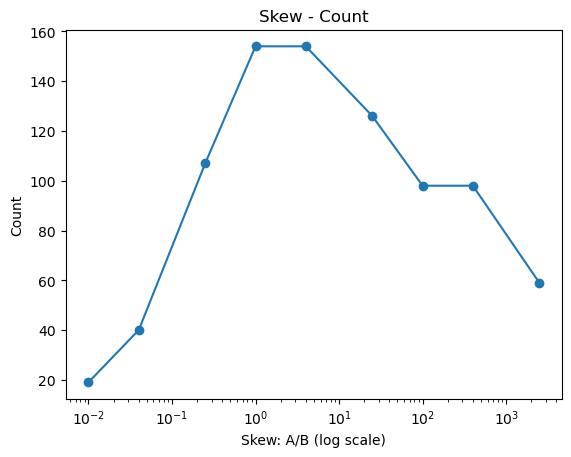

In [14]:
import matplotlib.pyplot as plt
candidate_A = [100, 200, 500, 1000, 2000, 5000, 10000, 20000, 50000]
count_of_A = []
for A in candidate_A:
    count_of_A.append(counting_ab(A))
    print(f"A: {A}, B:{10**6 // A}, skew: {A ** 2 / 10 ** 6}, count: {count_of_A[-1]}")
    
plt.xscale('log')

plt.plot([A**2 / 10**6 for A in candidate_A], count_of_A, marker='o')
# 添加标题和标签
plt.title('Skew - Count')
plt.xlabel('Skew: A/B (log scale)')
plt.ylabel('Count')

# 显示图形
plt.show()

### c_4的值与COUNT的关系

实验中调试参数的时候发现：当c_4为1，或者较小的时候，我们发现几乎找不到平滑的数(只有1-2个）

然而，当c_4不断扩大，达到60的时候，平滑的数很容易被发现（从19个开始）

但是，继续扩大c_4，平滑数的增长速度得不到提升

怀疑是c_4的因数越多，越好找到平滑数，但是存在边际效应。

## 总结
使用的各种参数：
$$ \left\{ \begin{array}{cl}
g(x) = 51213017x - 152037120783797 \\
f(x) = 2310x^4 -16695292x^3 + 49517869547863x^2 + 67001124626403x - 113113551578641
\end{array} \right. $$

一个A、B取值与count的例子：
$$ \left|\{ (a,b) \in [-1000, 1000] x [1, 1000] | b^4f(\frac{a}{b}), bg(\frac{a}{b})\ are\ smooth \}\right| = 154 $$

最佳$skew = A/B$取值范围：1~4